In [154]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

## Functions

In [155]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

In [156]:
def plot_hist_normalized(this_column):
    pt = PowerTransformer()
    col_transformed_pt=pt.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_pt).set(title=f"{this_column.name} - PowerTransformer") 
    sc = StandardScaler()
    col_transformed_sc=sc.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_sc).set(title=f"{this_column.name} - StandardScaler")
    qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
    col_transformed_qt=qt.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_qt).set(title=f"{this_column.name} - QuantileTransformer")

In [157]:
def boxplots_for_all_numerical_cols(this_df):
    fig, ax = plt.subplots(figsize=(10,10))
    len_num_lst = len(split_column_names_by(this_df)[0])
    i = 1
    for col in split_column_names_by(this_df)[0]:            
        plt.subplot(math.ceil(len_num_lst**.5),math.ceil(len_num_lst**.5),i)
        sns.boxplot(y=this_df[col]).set(title=f"{col}")
        i += 1

In [158]:
def split_df_by(this_df, include_dtypes:[list]=["int","float"]):
    """takes in this_df, splits it into two NEW DF's by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_df, excl_df)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (this_df[incl_lst], this_df[excl_lst])

In [159]:
def all_numeric_to_int(this_df):
    for col in split_df_in_numeric_categ_dfs(this_df)[0]:
        this_df[col] = this_df[col].astype(np.int64)


## Read and Clean

In [160]:
ca_df = pd.read_csv("C:/Users/roman/Documents/GitHub/Customer_Data_Analysis/Data/marketing_cust_analysis_round2.csv")
ca_df.columns

Index(['customer', 'state', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'employmentstatus', 'gender',
       'income', 'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size', 'vehicle_type', 'month'],
      dtype='object')

### Numerical columns

#### Boxplots

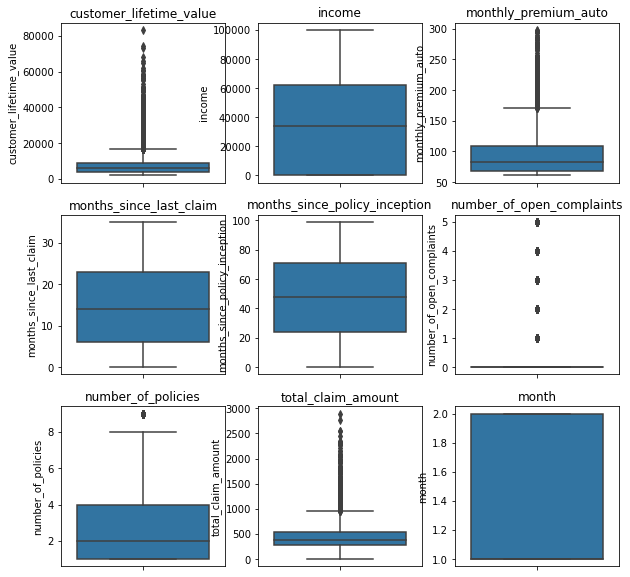

In [161]:
boxplots_for_all_numerical_cols(ca_df)

#### Check for NaNs

In [162]:
for col in split_column_names_by(ca_df)[0]:
    print(f"{col}: {ca_df[col].isna().sum()}")

customer_lifetime_value: 0
income: 0
monthly_premium_auto: 0
months_since_last_claim: 633
months_since_policy_inception: 0
number_of_open_complaints: 633
number_of_policies: 0
total_claim_amount: 0
month: 0


In [163]:
ca_df["months_since_last_claim"].value_counts()

3.0     426
6.0     394
1.0     386
7.0     378
4.0     373
2.0     368
5.0     355
0.0     354
10.0    346
16.0    333
11.0    331
15.0    323
13.0    320
8.0     315
12.0    307
17.0    299
14.0    299
9.0     277
23.0    276
19.0    276
25.0    269
21.0    267
18.0    257
20.0    254
22.0    246
24.0    237
29.0    234
28.0    227
31.0    221
26.0    211
27.0    208
30.0    201
34.0    199
33.0    198
35.0    157
32.0    155
Name: months_since_last_claim, dtype: int64

NaN will be replaced with mean of months_since_last_claim

In [164]:
ca_df["months_since_last_claim"].fillna(np.mean(ca_df["months_since_last_claim"]), inplace=True)

**Change appropriate numerical columns to categorical**

In [165]:
for col in ["number_of_open_complaints","number_of_policies", "month"]:
    ca_df[col] = ca_df[col].astype('category')

*placeholder*

**Categorical columns**

In [166]:
print(split_column_names_by(ca_df)[1])

['customer', 'state', 'response', 'coverage', 'education', 'effective_to_date', 'employmentstatus', 'gender', 'location_code', 'marital_status', 'number_of_open_complaints', 'number_of_policies', 'policy_type', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class', 'vehicle_size', 'vehicle_type', 'month']


**drop some columns:**
+ customer → kind of primary key
+ effective to date → does not seem to have an effect for the model

In [167]:
ca_df.drop(["customer", "effective_to_date"], axis=1, inplace=True)

In [168]:
print(split_column_names_by(ca_df)[1])

['state', 'response', 'coverage', 'education', 'employmentstatus', 'gender', 'location_code', 'marital_status', 'number_of_open_complaints', 'number_of_policies', 'policy_type', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class', 'vehicle_size', 'vehicle_type', 'month']


## Normalizing

### Dataframe with 0 income dropped

In [120]:
ca_no_zero_income_df = ca_df[ca_df["income"] != 0]
# len(ca_no_zero_income_df)

In [121]:
split_column_names_by(ca_no_zero_income_df)[0]

['customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'months_since_last_claim',
 'months_since_policy_inception',
 'total_claim_amount']

#### Different transformations (zero income dropped)

##### Numerical

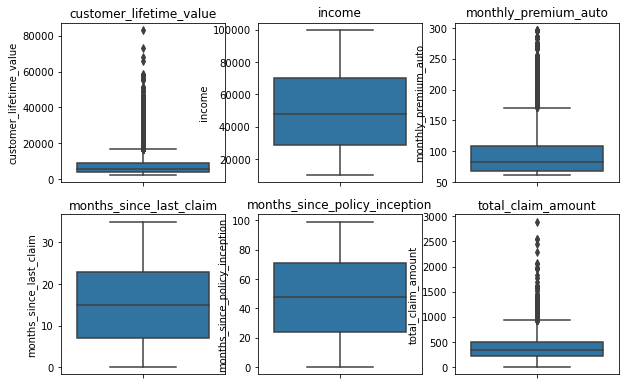

In [122]:
boxplots_for_all_numerical_cols(split_df_by(ca_no_zero_income_df)[0])

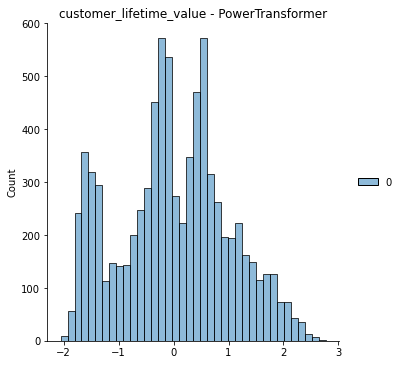

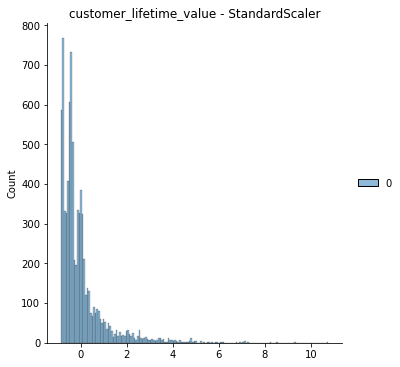

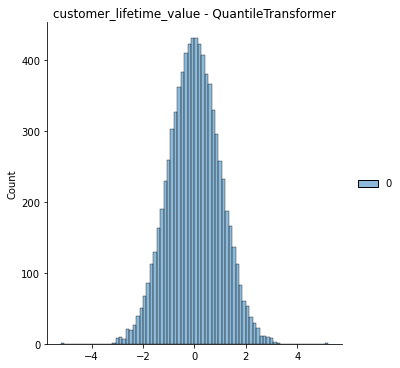

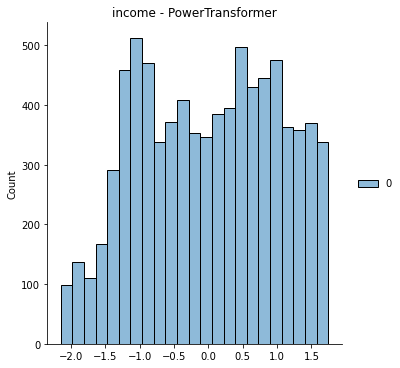

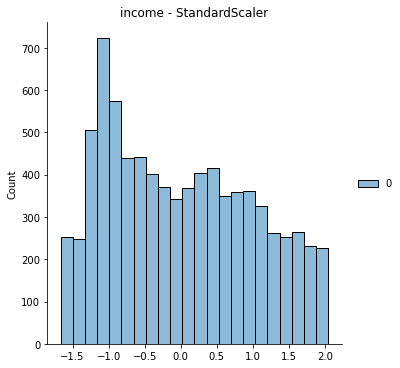

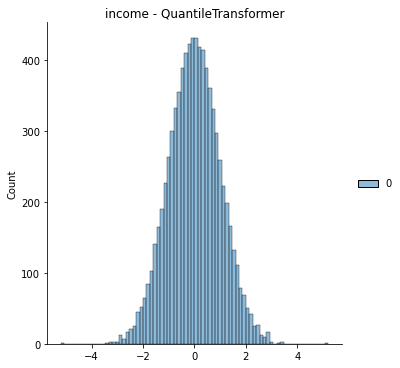

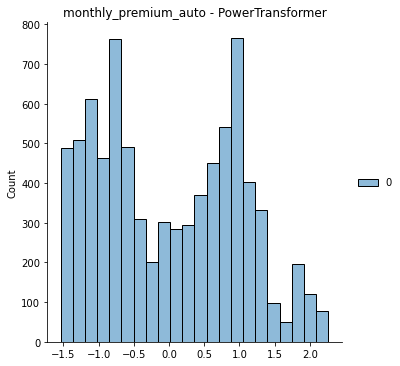

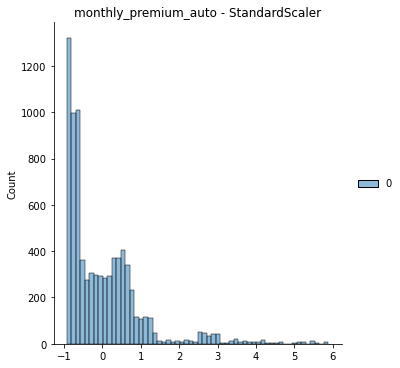

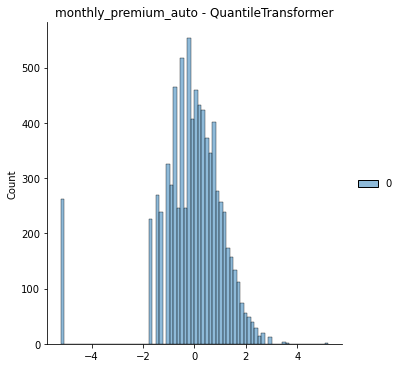

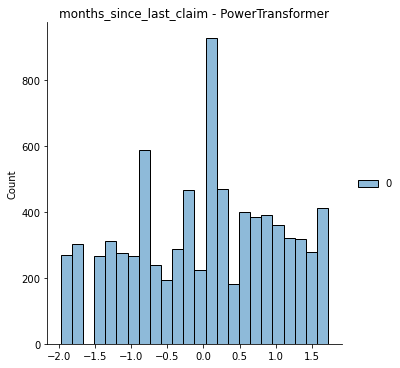

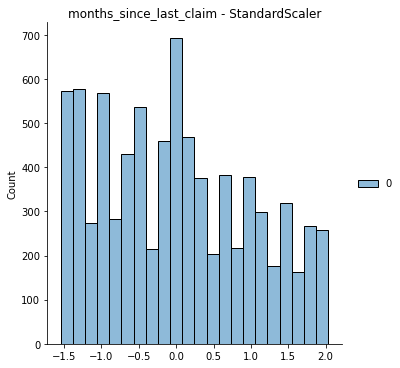

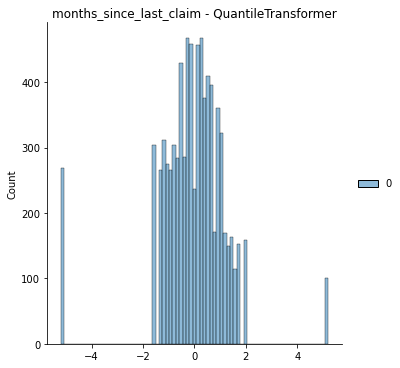

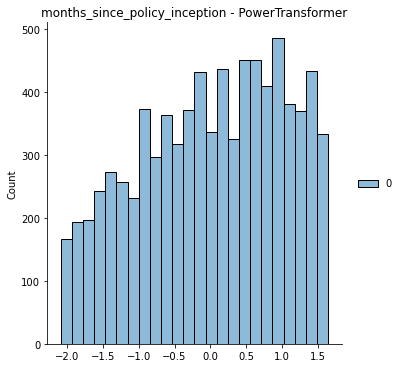

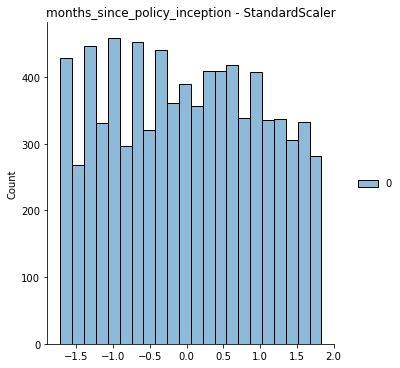

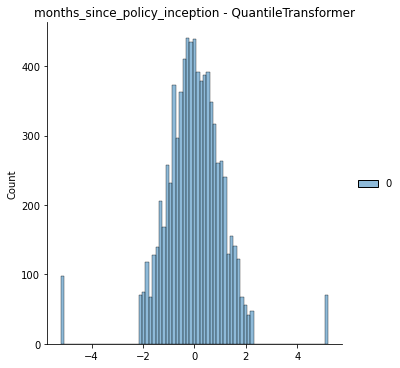

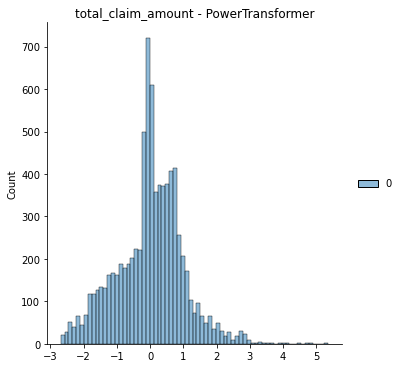

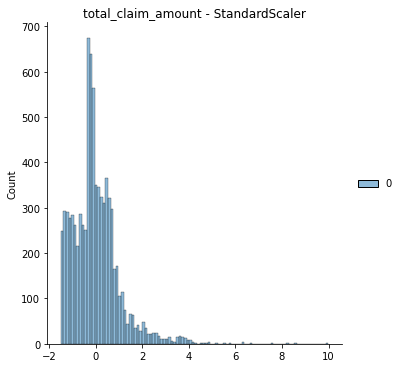

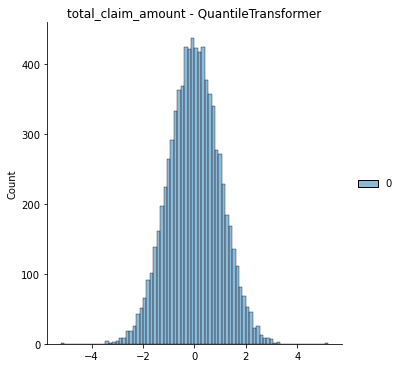

In [123]:
for col in split_column_names_by(ca_no_zero_income_df)[0]:
    plot_hist_normalized(ca_no_zero_income_df[col])

In [124]:
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
ca_no_zero_income_df["customer_lifetime_value_qt"] = qt.fit_transform(ca_no_zero_income_df["customer_lifetime_value"].to_numpy().reshape(-1,1))
ca_no_zero_income_df["income_qt"] = qt.fit_transform(ca_no_zero_income_df["income"].to_numpy().reshape(-1,1))
ca_no_zero_income_df["monthly_premium_auto_qt"] = qt.fit_transform(ca_no_zero_income_df["monthly_premium_auto"].to_numpy().reshape(-1,1))
ca_no_zero_income_df["months_since_last_claim_qt"] = qt.fit_transform(ca_no_zero_income_df["months_since_last_claim"].to_numpy().reshape(-1,1))
ca_no_zero_income_df["months_since_policy_inception_qt"] = qt.fit_transform(ca_no_zero_income_df["months_since_policy_inception"].to_numpy().reshape(-1,1))
ca_no_zero_income_df.drop(["income","customer_lifetime_value","monthly_premium_auto","months_since_last_claim","months_since_policy_inception"], axis=1, inplace=True)


C:\Users\roman\AppData\Local\Temp/ipykernel_18692/3645215873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_no_zero_income_df["customer_lifetime_value_qt"] = qt.fit_transform(ca_no_zero_income_df["customer_lifetime_value"].to_numpy().reshape(-1,1))
C:\Users\roman\AppData\Local\Temp/ipykernel_18692/3645215873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_no_zero_income_df["income_qt"] = qt.fit_transform(ca_no_zero_income_df["income"].to_numpy().reshape(-1,1))
C:\Users\roman\AppData\Local\Tem

##### Categorical

In [125]:
categoricals_features= ca_no_zero_income_df.select_dtypes("object")
len(categoricals_features)

8123

In [126]:
# for col in categoricals_features.columns:
#     print(f"{col}:\n", categoricals_features[col].value_counts(),"\n  - - - - - -")

In [127]:
cat_cols_no_zero_income=pd.get_dummies(categoricals_features, drop_first=True)

In [128]:
cat_cols_no_zero_income

,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
10903,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,0
10906,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


#### X-y split

In [129]:
X=ca_no_zero_income_df.drop("total_claim_amount", axis=1)
y=ca_no_zero_income_df["total_claim_amount"]

In [130]:
X=X._get_numeric_data()
X

,customer_lifetime_value_qt,income_qt,monthly_premium_auto_qt,months_since_last_claim_qt,months_since_policy_inception_qt
0,-0.442432,-0.004804,-5.199338,-0.635580,0.118323
2,1.226274,-1.170743,0.402420,2.013252,-0.454737
3,1.624785,0.027116,0.332543,-0.383428,-1.785697
4,0.659579,-1.023183,1.026599,0.100636,-0.454737
5,-0.470810,0.063463,-5.199338,-1.358362,0.737330
...,...,...,...,...,...
10902,-0.820847,-0.680330,0.192060,-0.383428,-0.482771
10903,-1.206187,0.340674,-0.192060,1.315396,1.070111
10906,-0.235764,0.391770,-1.065669,-0.635580,0.575238
10907,1.717269,-0.231646,2.061689,-0.295601,0.432565


array([[<AxesSubplot:title={'center':'customer_lifetime_value_qt'}>,
        <AxesSubplot:title={'center':'income_qt'}>],
       [<AxesSubplot:title={'center':'monthly_premium_auto_qt'}>,
        <AxesSubplot:title={'center':'months_since_last_claim_qt'}>],
       [<AxesSubplot:title={'center':'months_since_policy_inception_qt'}>,
        <AxesSubplot:>]], dtype=object)

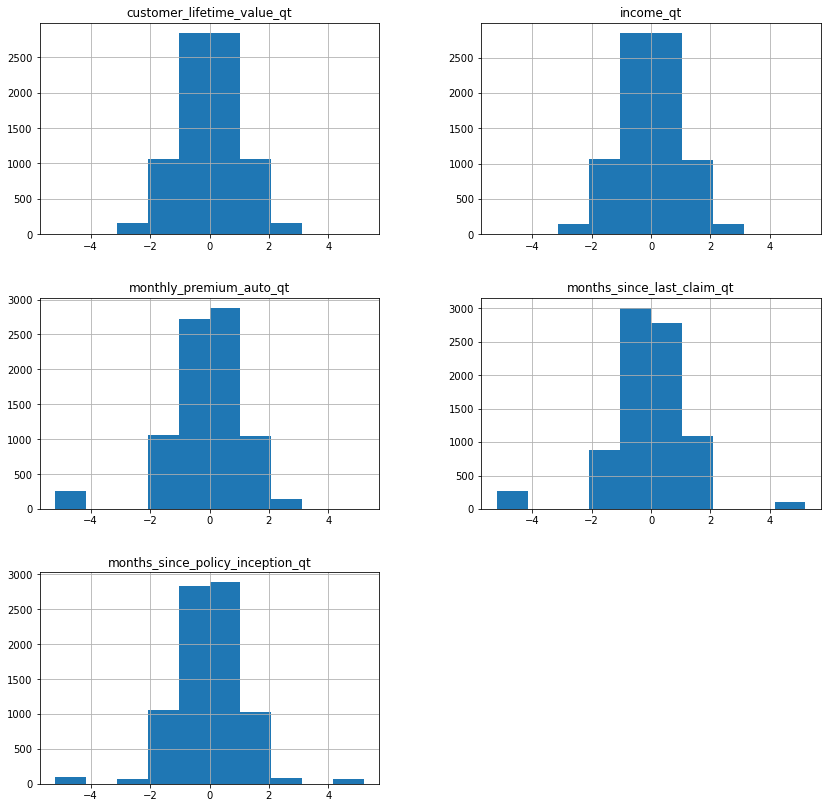

In [131]:
X.hist(figsize=(14,14))

**Concat dummies to numeric standardized**

In [132]:
X = pd.concat([X,cat_cols_no_zero_income],axis=1)
X

,customer_lifetime_value_qt,income_qt,monthly_premium_auto_qt,months_since_last_claim_qt,months_since_policy_inception_qt,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,-0.442432,-0.004804,-5.199338,-0.635580,0.118323,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.226274,-1.170743,0.402420,2.013252,-0.454737,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,1.624785,0.027116,0.332543,-0.383428,-1.785697,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0.659579,-1.023183,1.026599,0.100636,-0.454737,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
5,-0.470810,0.063463,-5.199338,-1.358362,0.737330,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,-0.820847,-0.680330,0.192060,-0.383428,-0.482771,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10903,-1.206187,0.340674,-0.192060,1.315396,1.070111,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
10906,-0.235764,0.391770,-1.065669,-0.635580,0.575238,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,1.717269,-0.231646,2.061689,-0.295601,0.432565,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


#### Data splitting

In [133]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=42)

#### Standardize
+ Build scaling parameters on training set (mean variance) → more data as approx 80 % of sample <br>



In [134]:
std_scaler=StandardScaler().fit(X_train)

+ Apply on training set

In [135]:
X_train_scaled=std_scaler.transform(X_train)
# np.argwhere(np.isnan(X_train_scaled))

+ as well as on test set (same std_scaler but generated by a bigger set of values), same scaling param's as x_train

In [136]:
X_test_scaled=std_scaler.transform(X_test)

In [137]:
# print("X_train_scaled:")
# print(X_train_scaled)
# print("--------\nX_text_scaled:")
# print(X_test_scaled)

#### Modeling using Statsmodels

In [138]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     412.8
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:04:53   Log-Likelihood:                -35244.
No. Observations:                5686   AIC:                         7.058e+04
Df Residuals:                    5640   BIC:                         7.088e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        377.1056      1.585    237.927      0.0

In [139]:
predictions_test

array([435.53832878, 404.49460519, 524.03191398, ..., 172.57393804,
       226.27582729, 770.6778634 ])

In [140]:
#display adjusted R-squared
# print(model.rsquared_adj)

#### Modeling using Scikit Learn

##### Model fitting

In [141]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### Parameters of model

In [142]:
model.coef_

array([ 1.12162978e+01, -5.27998339e+00,  2.29337591e+01,  2.65765052e+00,
        3.38250320e+00,  1.31897215e+00,  1.33201403e+00,  2.57410679e+00,
        3.52172016e+00, -1.02814203e+00,  2.78797448e+01,  5.04662578e+01,
       -9.71802323e-01, -2.49598493e+00,  7.87602049e-01,  1.17237207e+00,
       -5.19598547e+00, -4.98907317e-01, -4.36935747e+00,  4.48960777e+00,
        1.90053147e+02,  9.25527338e+01, -2.64957588e+00,  3.02026152e+00,
        6.22529801e+13,  5.58336324e+13, -1.54983533e+00, -1.73191775e-01,
       -4.85476399e+13, -6.05072727e+13, -6.92268836e+13, -2.70480579e+13,
       -3.58257103e+13, -3.45575561e+13,  3.63823836e+00,  1.49163758e+00,
        2.98616093e+00, -1.02280006e+00, -1.41848545e+00,  2.11917069e+00,
        6.24264936e+01,  6.87922564e+01,  5.18914817e+01,  2.59947391e+01,
       -2.28858562e+00, -1.19323354e+01, -9.18574313e+00])

In [143]:
model.intercept_

377.09979582793926

y = 377.11 + <br>23.39 * customer_lifetime_value  - 54.61 * income + 104.07 * monthly_premium_auto - 2.68 * months_since_last_claim - 0.11 * months_since_policy_inception 

In [144]:
model.score(X_test_scaled,y_test)

0.7597501479108774

##### Making prediction

In [145]:
y_pred=model.predict(X_test_scaled)

In [146]:
y_test

2625     389.636991
6302     497.047297
7355     527.139074
8803       5.746657
7944    1108.800000
           ...     
5157     114.815893
635      574.024018
2601      40.839965
5088     171.184016
1077     888.000000
Name: total_claim_amount, Length: 2437, dtype: float64

In [147]:
len(y_pred)

2437

In [148]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### Plots

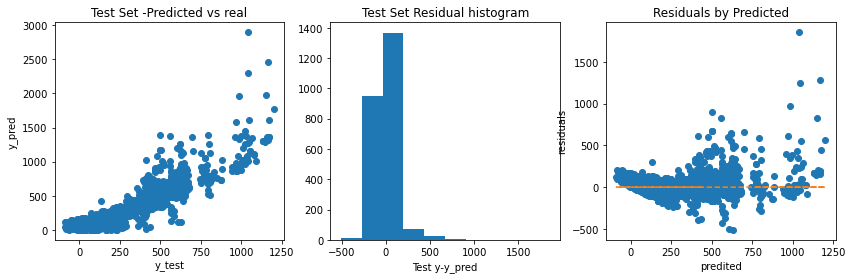

In [149]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

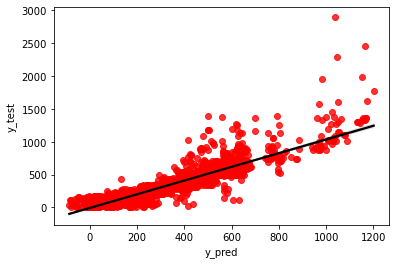

In [150]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

##### Error metrics

In [151]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

16716.337596014804
82.80288061449966


In [152]:
R2=r2_score(y_test,y_pred)
R2

0.7597501479108774

In [153]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.7550235915909993

### Dataframe with 0 income replaced by mean income

+ mean of income *including* the 0 incomes

In [52]:
np.mean(ca_df["income"])

37536.28478460128

+ mean of income *excluding* 0 incomes

In [53]:
np.mean(ca_df[ca_df["income"] != 0]["income"])

50414.9780869137

In [54]:
ca_zero_income_mean_df = ca_df

In [55]:
ca_zero_income_mean_df['income']=ca_zero_income_mean_df['income'].replace(0, np.mean(ca_df[ca_df["income"] != 0]["income"]))


#### Different transformations (zero income dropped)

##### Numerical

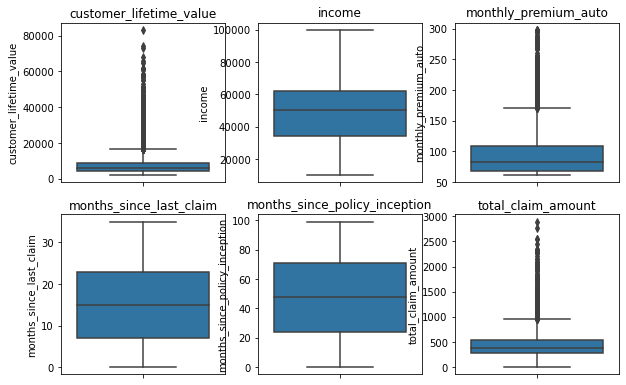

In [56]:
boxplots_for_all_numerical_cols(split_df_by(ca_zero_income_mean_df)[0])

C:\Users\roman\Python\anaconda\envs\DA_Env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


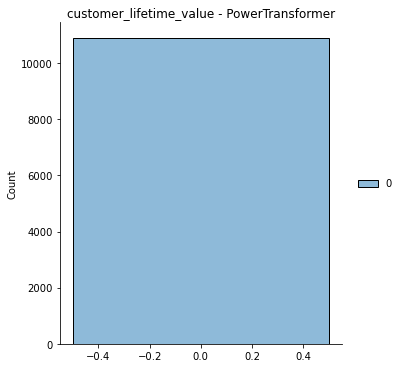

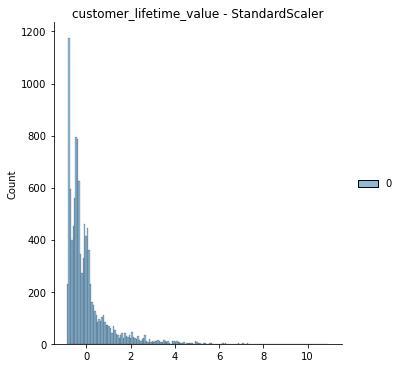

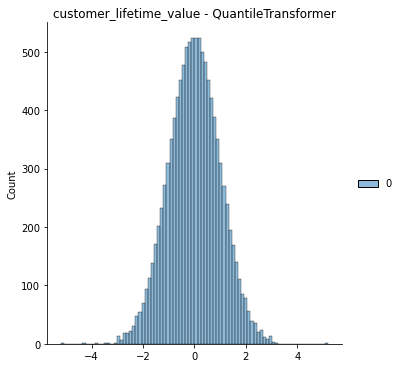

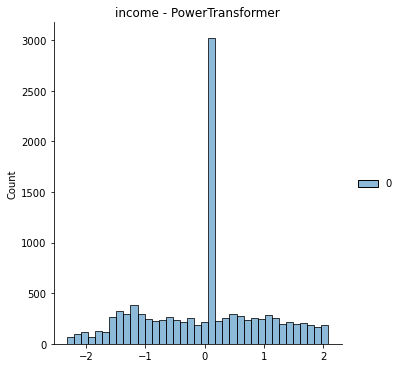

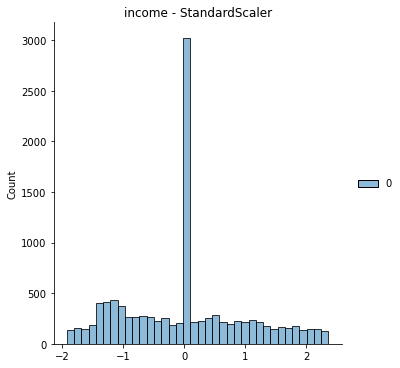

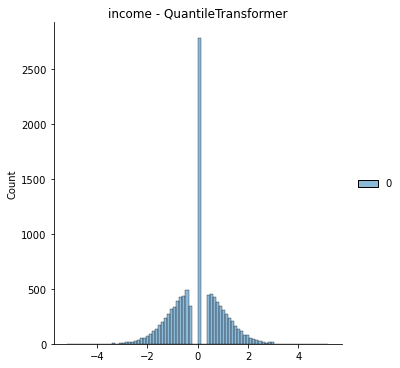

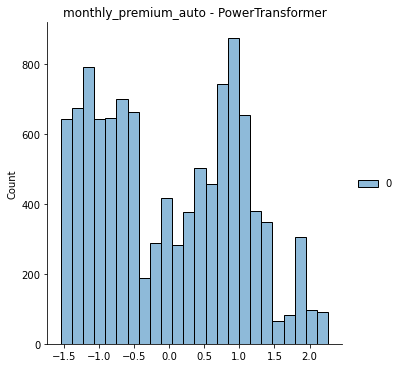

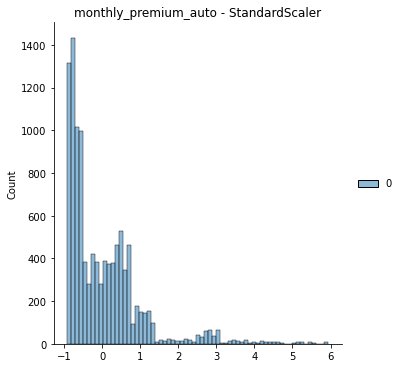

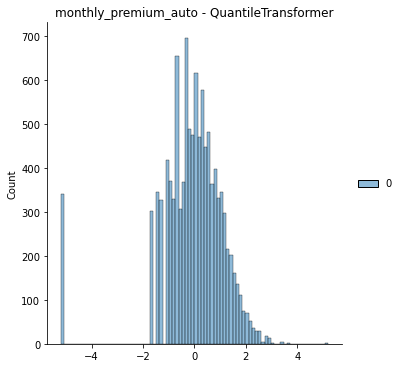

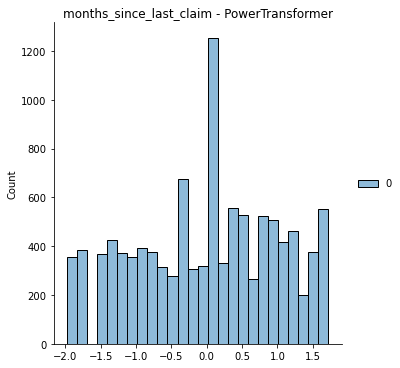

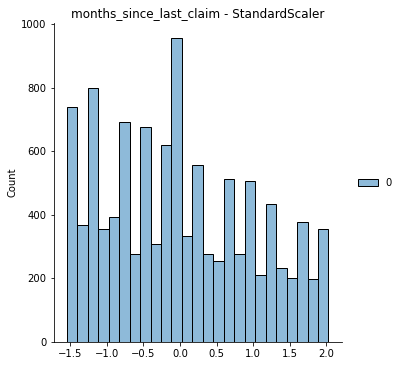

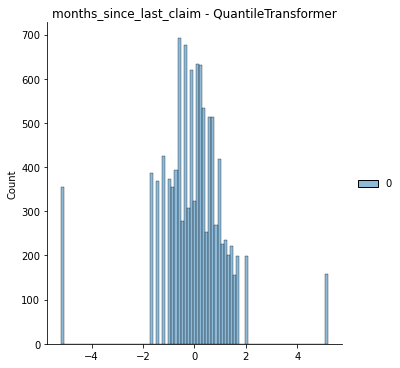

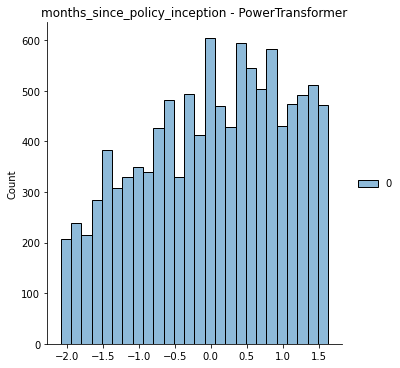

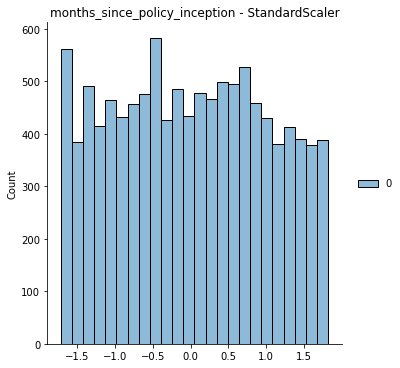

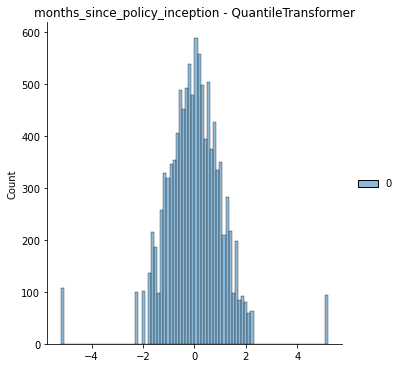

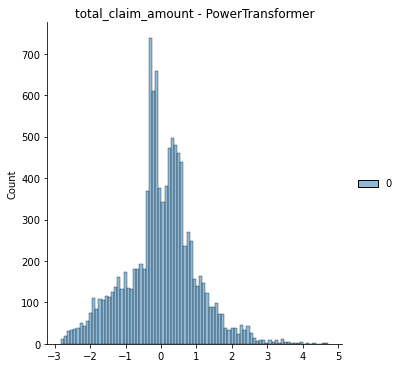

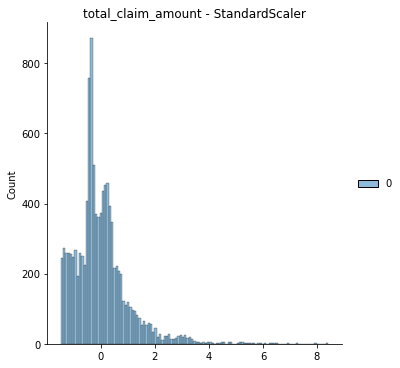

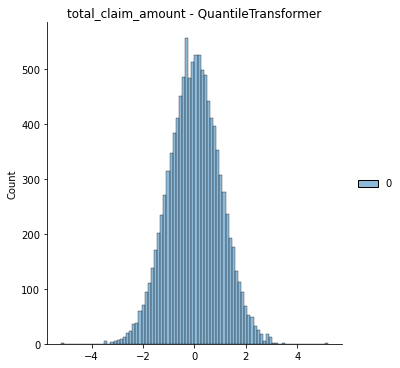

In [57]:
for col in split_column_names_by(ca_zero_income_mean_df)[0]:
    plot_hist_normalized(ca_zero_income_mean_df[col])

In [58]:
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
ca_zero_income_mean_df["customer_lifetime_value_qt"] = qt.fit_transform(ca_zero_income_mean_df["customer_lifetime_value"].to_numpy().reshape(-1,1))
ca_zero_income_mean_df["income_qt"] = qt.fit_transform(ca_zero_income_mean_df["income"].to_numpy().reshape(-1,1))
ca_zero_income_mean_df["monthly_premium_auto_qt"] = qt.fit_transform(ca_zero_income_mean_df["monthly_premium_auto"].to_numpy().reshape(-1,1))
ca_zero_income_mean_df["months_since_last_claim_qt"] = qt.fit_transform(ca_zero_income_mean_df["months_since_last_claim"].to_numpy().reshape(-1,1))
ca_zero_income_mean_df["months_since_policy_inception_qt"] = qt.fit_transform(ca_zero_income_mean_df["months_since_policy_inception"].to_numpy().reshape(-1,1))
ca_zero_income_mean_df.drop(["income","customer_lifetime_value","monthly_premium_auto","months_since_last_claim","months_since_policy_inception"], axis=1, inplace=True)

##### Categorical

In [59]:
categoricals_features= ca_zero_income_mean_df.select_dtypes("object")
len(categoricals_features)

10910

In [60]:
categoricals_features

,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,vehicle_type
0,Arizona,No,Basic,College,Employed,M,Suburban,Married,Corporate Auto,Corporate L3,Offer3,Agent,Four-Door Car,Medsize,NaN
1,California,No,Basic,College,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer4,Call Center,Four-Door Car,Medsize,NaN
2,Washington,No,Basic,Bachelor,Employed,M,Suburban,Single,Personal Auto,Personal L3,Offer3,Call Center,SUV,Medsize,A
3,Oregon,Yes,Extended,College,Employed,M,Suburban,Single,Corporate Auto,Corporate L3,Offer2,Branch,Four-Door Car,Medsize,A
4,Oregon,No,Premium,Bachelor,Medical Leave,F,Suburban,Married,Personal Auto,Personal L2,Offer1,Branch,Four-Door Car,Medsize,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,Nevada,No,Premium,Bachelor,Unemployed,F,Suburban,Married,Personal Auto,Personal L1,Offer3,Web,Luxury Car,Medsize,A
10906,Oregon,No,Basic,College,Employed,F,Urban,Married,Personal Auto,Personal L3,Offer2,Branch,Four-Door Car,Medsize,A
10907,Arizona,No,Extended,Bachelor,Employed,F,Rural,Married,Corporate Auto,Corporate L3,Offer1,Web,Luxury SUV,Medsize,NaN
10908,California,No,Premium,College,Employed,F,Urban,Divorced,Personal Auto,Personal L1,Offer1,Branch,SUV,Medsize,A


In [61]:
ca_zero_income_mean_df["policy"].value_counts()

Personal L3     4118
Personal L2     2537
Personal L1     1473
Corporate L3    1221
Corporate L2     688
Corporate L1     432
Special L2       193
Special L3       170
Special L1        78
Name: policy, dtype: int64

In [62]:
ca_zero_income_mean_df["policy_type"].value_counts()

Personal Auto     8128
Corporate Auto    2341
Special Auto       441
Name: policy_type, dtype: int64

In [63]:
# count values
# for col in categoricals_features.columns:
#     print(f"{col}:\n", categoricals_features[col].value_counts(),"\n  - - - - - -")


In [64]:
cat_cols_zero_income_mean=pd.get_dummies(categoricals_features, drop_first=True)

In [65]:
cat_cols_zero_income_mean

,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,1,0
10906,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
10908,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0,1,0


#### X-y split

In [66]:
X=ca_zero_income_mean_df.drop("total_claim_amount", axis=1)
y=ca_zero_income_mean_df["total_claim_amount"]

In [67]:
X=X._get_numeric_data()
X

,customer_lifetime_value_qt,income_qt,monthly_premium_auto_qt,months_since_last_claim_qt,months_since_policy_inception_qt
0,-0.394156,-0.329890,-5.199338,-0.641740,0.110739
1,-2.336103,0.045225,-1.246925,-1.168798,-0.623332
2,1.239759,-1.342359,0.394263,1.976518,-0.463109
3,1.667594,-0.305638,0.327239,-0.391550,-1.811004
4,0.680647,-1.204088,0.993141,0.093065,-0.463109
...,...,...,...,...,...
10905,1.285817,0.045225,2.566000,0.093065,-0.212569
10906,-0.195135,0.647952,-1.079060,-0.641740,0.566370
10907,1.753037,-0.511949,2.106144,-0.308746,0.424306
10908,0.989715,0.732501,1.621036,-5.199338,-0.593112


array([[<AxesSubplot:title={'center':'customer_lifetime_value_qt'}>,
        <AxesSubplot:title={'center':'income_qt'}>],
       [<AxesSubplot:title={'center':'monthly_premium_auto_qt'}>,
        <AxesSubplot:title={'center':'months_since_last_claim_qt'}>],
       [<AxesSubplot:title={'center':'months_since_policy_inception_qt'}>,
        <AxesSubplot:>]], dtype=object)

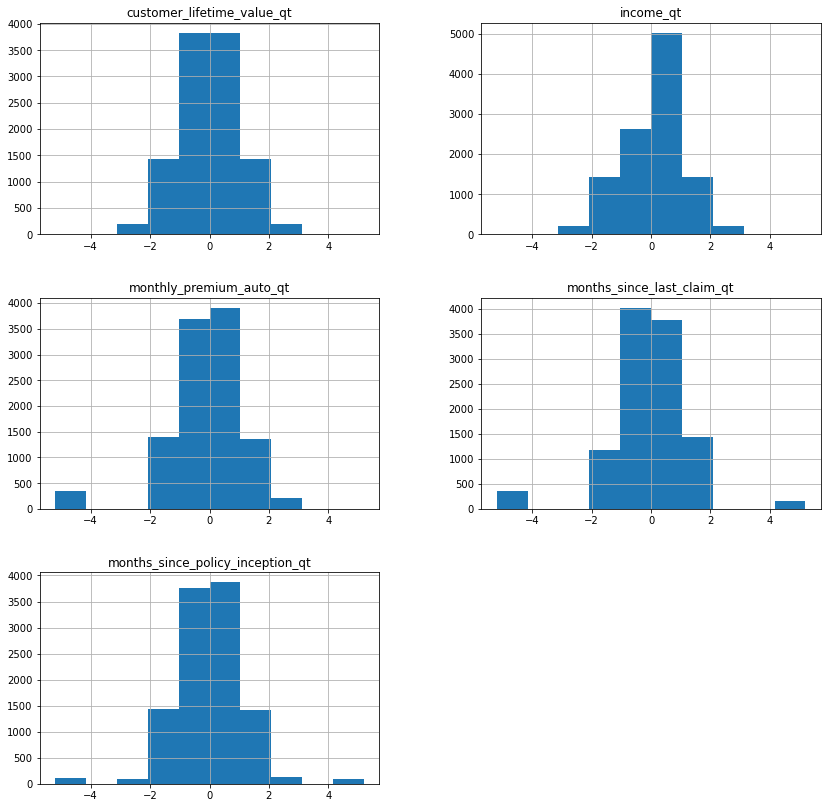

In [68]:
X.hist(figsize=(14,14))

**Concat dummies to numeric standardized**

In [69]:
X = pd.concat([X,cat_cols_zero_income_mean],axis=1)
X

,customer_lifetime_value_qt,income_qt,monthly_premium_auto_qt,months_since_last_claim_qt,months_since_policy_inception_qt,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,-0.394156,-0.329890,-5.199338,-0.641740,0.110739,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-2.336103,0.045225,-1.246925,-1.168798,-0.623332,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,1.239759,-1.342359,0.394263,1.976518,-0.463109,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,1.667594,-0.305638,0.327239,-0.391550,-1.811004,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0.680647,-1.204088,0.993141,0.093065,-0.463109,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,1.285817,0.045225,2.566000,0.093065,-0.212569,0,1,0,0,0,...,0,0,1,1,0,0,0,0,1,0
10906,-0.195135,0.647952,-1.079060,-0.641740,0.566370,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,1.753037,-0.511949,2.106144,-0.308746,0.424306,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
10908,0.989715,0.732501,1.621036,-5.199338,-0.593112,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


#### Data splitting

In [70]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=42)

#### Standardize

+ Build scaling parameters on training set (mean variance)

In [71]:
std_scaler=StandardScaler().fit(X_train)

+ Apply on training set

In [72]:
X_train_scaled=std_scaler.transform(X_train)
# np.argwhere(np.isnan(X_train_scaled))

+ as well as on test set (same std_scaler but generated by a bigger set of values)

In [73]:
X_test_scaled=std_scaler.transform(X_test)

# print("X_train_scaled:")
# print(X_train_scaled)
# print("--------\nX_text_scaled:")
# print(X_test_scaled)


#### Modeling using Statsmodels

In [74]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

In [75]:
model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     470.3
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:03:59   Log-Likelihood:                -49096.
No. Observations:                7637   AIC:                         9.829e+04
Df Residuals:                    7590   BIC:                         9.861e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        435.4308      1.720    253.112      0.0

In [76]:
predictions_test

array([386.7527491 , 419.24581137, 540.21273089, ..., 266.60294534,
       203.86304625, 298.38519658])

In [77]:
# display adjusted R-squared
# print(model.rsquared_adj)


#### Modeling using Scikit Learn

##### Model fitting

In [78]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### Parameters of model

In [79]:
print("Coefficients:\n", model.coef_)
print("Interecept:", model.intercept_)

Coefficients:
 [ 7.94402618e+00 -5.77559558e+00  2.96063384e+01  3.25133499e+00
  1.23110284e+00  4.08753561e+00  2.94088042e+00  1.20360129e+00
  3.30482077e+00 -7.38145210e+00  3.11952777e+01  5.87906217e+01
 -4.12270776e+00 -2.40247746e+00  4.28869793e+00 -1.73229785e+00
 -5.50060231e+00  5.89356914e-01 -2.80028893e+00  2.89258758e+01
  8.60021635e+00  1.86782526e+02  8.55124973e+01 -1.70371621e+00
  2.96797631e+01 -8.75545711e+13 -6.47969798e+13  1.97227141e+00
  1.96135532e+00  6.87925878e+13  8.42644418e+13  9.73688997e+13
  2.90791236e+13  4.43385402e+13  3.87120724e+13  7.68808425e+00
  3.91847103e+00  1.59689490e+00 -2.29462394e+00 -1.02511189e+00
  4.39293612e-01  8.23477931e+01  8.54167804e+01  6.40947106e+01
  3.54253122e+01 -9.10462006e-01 -1.30770274e+01 -7.71000662e+00]
Interecept: 435.41973630638347


y = 435.43 + <br>
16.04 * customer_lifetime_value  - 47.18 * income + 131.36 * monthly_premium_auto + 3.76 * months_since_last_claim + 1.70 * months_since_policy_inception 


In [80]:
model.score(X_test_scaled,y_test)

0.7444598455274544

##### Making prediction

In [81]:
y_pred=model.predict(X_test_scaled)

In [82]:
y_test

4829     475.423848
5081     350.400000
5011     482.400000
4625     673.342650
3838     302.400000
            ...    
9968     144.728404
5239      93.566940
10001    253.637853
4828     284.000172
10483    485.183645
Name: total_claim_amount, Length: 3273, dtype: float64

In [83]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### Plots

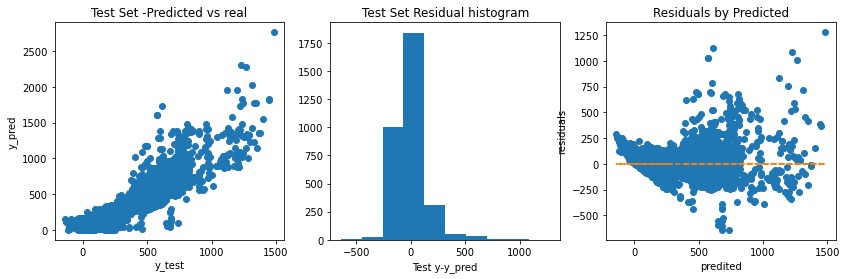

In [84]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

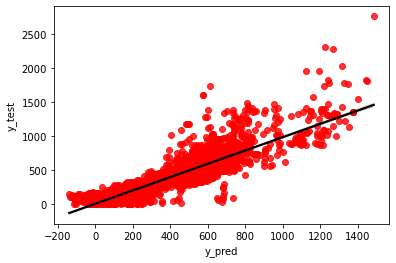

In [85]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})


##### Error metrics


In [86]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

21142.072006527924
100.43702109514652


In [87]:
R2=r2_score(y_test,y_pred)
R2

0.7444598455274544

In [88]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.7406552774707911

### Dataframe with 0 income dropped, policy dropped (policy_type kept)

In [169]:
ca_no_zero_two = ca_df[ca_df["income"] != 0]
ca_no_zero_two.drop("policy", axis=1)
len(ca_no_zero_two)

8123

#### Different transformations (zero income dropped)

##### Numerical

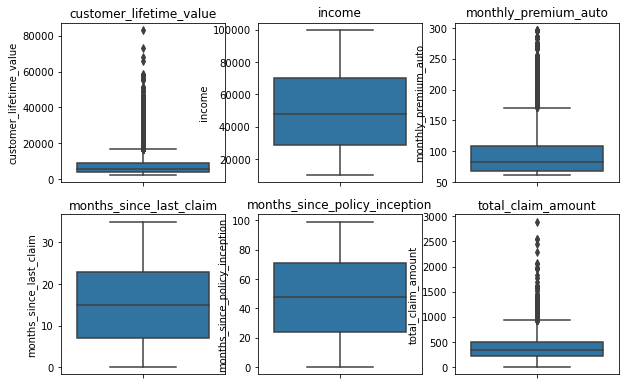

In [170]:
boxplots_for_all_numerical_cols(split_df_by(ca_no_zero_two)[0])

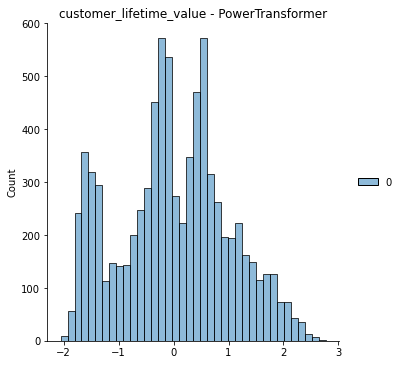

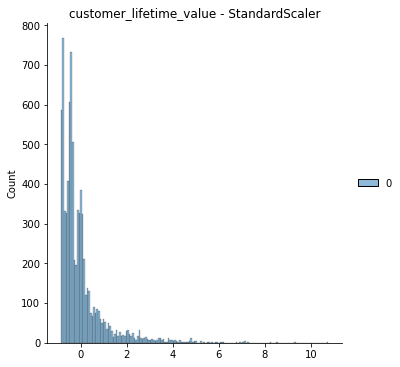

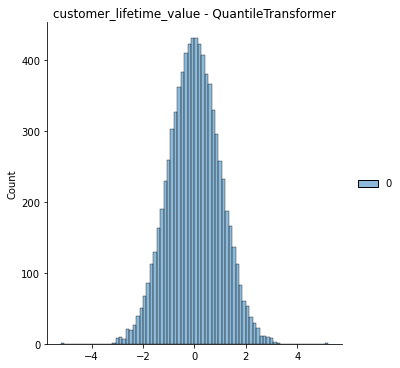

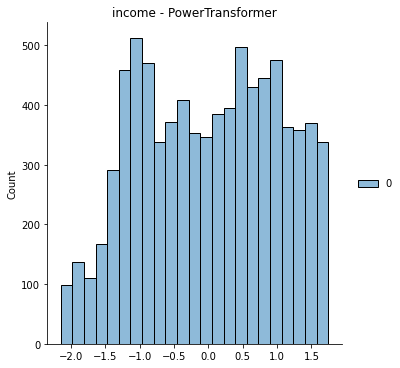

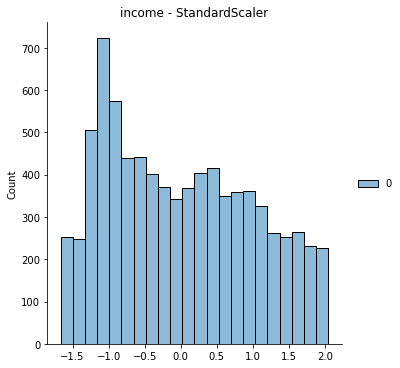

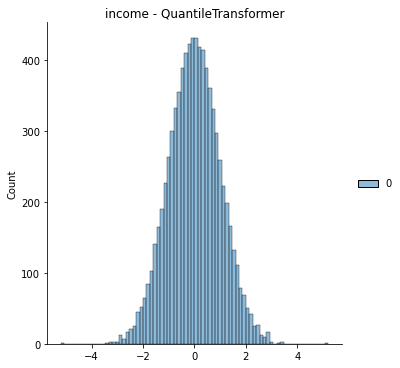

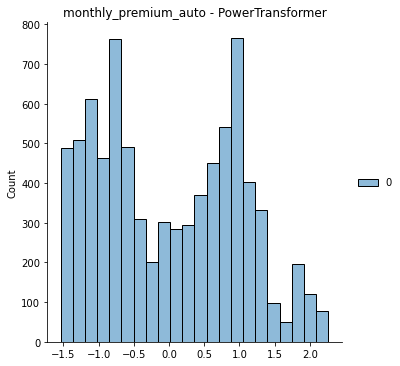

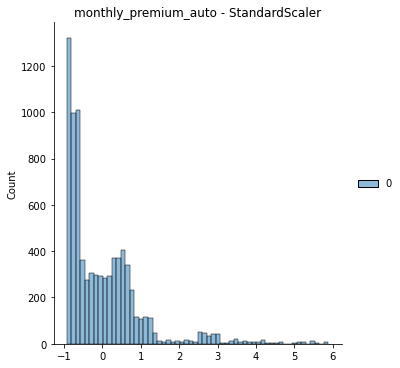

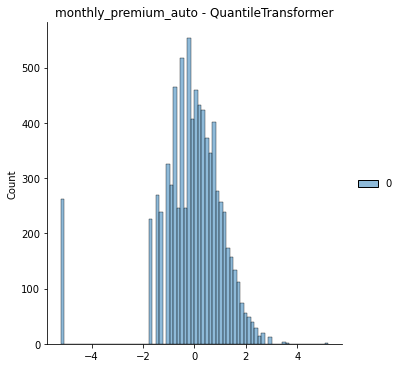

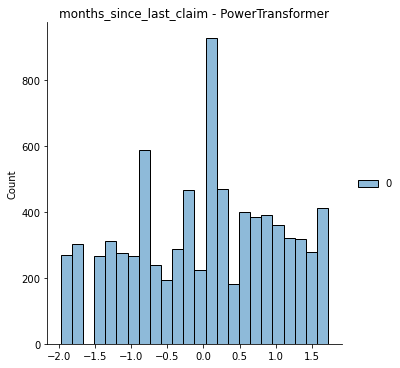

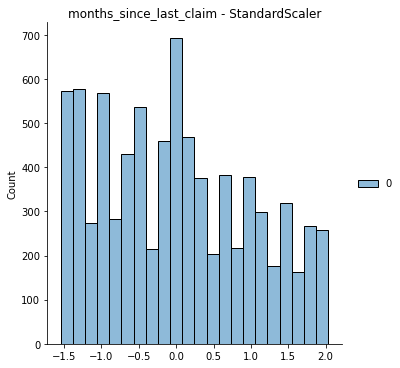

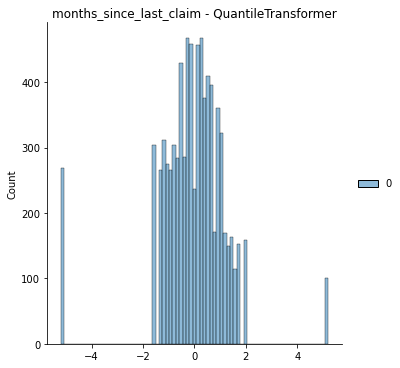

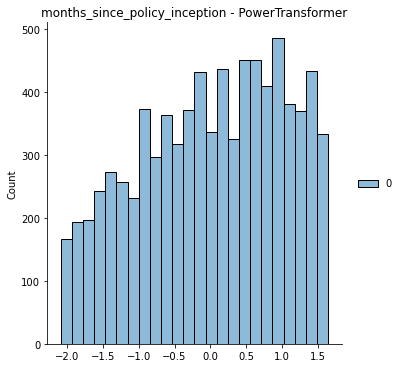

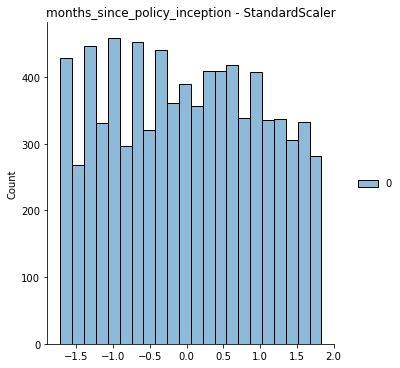

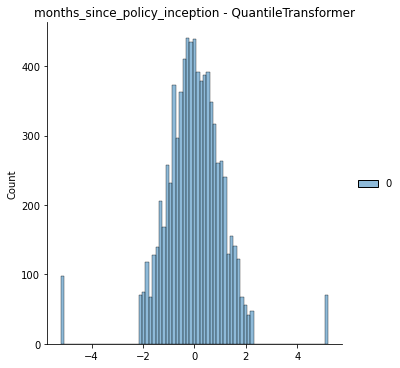

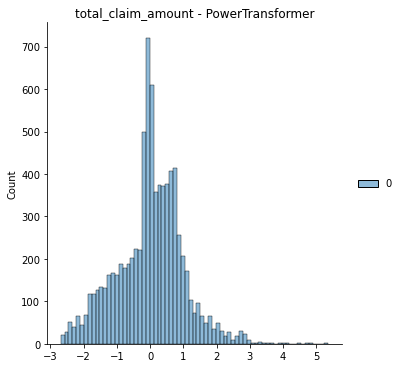

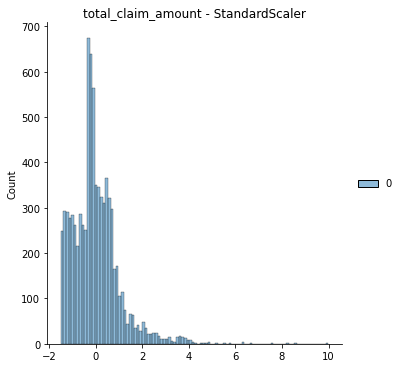

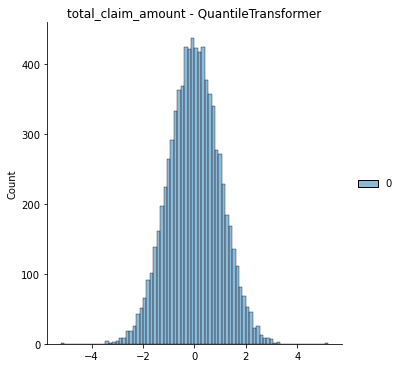

In [171]:
for col in split_column_names_by(ca_no_zero_two)[0]:
    plot_hist_normalized(ca_no_zero_two[col])

In [172]:
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
ca_no_zero_two["customer_lifetime_value_qt"] = qt.fit_transform(ca_no_zero_two["customer_lifetime_value"].to_numpy().reshape(-1,1))
ca_no_zero_two["income_qt"] = qt.fit_transform(ca_no_zero_two["income"].to_numpy().reshape(-1,1))
ca_no_zero_two["monthly_premium_auto_qt"] = qt.fit_transform(ca_no_zero_two["monthly_premium_auto"].to_numpy().reshape(-1,1))
ca_no_zero_two["months_since_last_claim_qt"] = qt.fit_transform(ca_no_zero_two["months_since_last_claim"].to_numpy().reshape(-1,1))
ca_no_zero_two["months_since_policy_inception_qt"] = qt.fit_transform(ca_no_zero_two["months_since_policy_inception"].to_numpy().reshape(-1,1))
ca_no_zero_two.drop(["income","customer_lifetime_value","monthly_premium_auto","months_since_last_claim","months_since_policy_inception"], axis=1, inplace=True)

C:\Users\roman\AppData\Local\Temp/ipykernel_18692/217204465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_no_zero_two["customer_lifetime_value_qt"] = qt.fit_transform(ca_no_zero_two["customer_lifetime_value"].to_numpy().reshape(-1,1))
C:\Users\roman\AppData\Local\Temp/ipykernel_18692/217204465.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_no_zero_two["income_qt"] = qt.fit_transform(ca_no_zero_two["income"].to_numpy().reshape(-1,1))
C:\Users\roman\AppData\Local\Temp/ipykernel_18692/21720446

##### Categorical


In [173]:
categoricals_features= ca_no_zero_two.select_dtypes("object")
# len(categoricals_features)

In [174]:
# for col in categoricals_features.columns:
#     print(f"{col}:\n", categoricals_features[col].value_counts(),"\n  - - - - - -")


In [175]:
cat_cols_no_zero_two=pd.get_dummies(categoricals_features, drop_first=True)
cat_cols_no_zero_two

,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
10903,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,0
10906,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


#### X-y split



In [176]:
X=ca_no_zero_two.drop("total_claim_amount", axis=1)
y=ca_no_zero_two["total_claim_amount"]

In [177]:
X=X._get_numeric_data()
X

,customer_lifetime_value_qt,income_qt,monthly_premium_auto_qt,months_since_last_claim_qt,months_since_policy_inception_qt
0,-0.442432,-0.004804,-5.199338,-0.635580,0.118323
2,1.226274,-1.170743,0.402420,2.013252,-0.454737
3,1.624785,0.027116,0.332543,-0.383428,-1.785697
4,0.659579,-1.023183,1.026599,0.100636,-0.454737
5,-0.470810,0.063463,-5.199338,-1.358362,0.737330
...,...,...,...,...,...
10902,-0.820847,-0.680330,0.192060,-0.383428,-0.482771
10903,-1.206187,0.340674,-0.192060,1.315396,1.070111
10906,-0.235764,0.391770,-1.065669,-0.635580,0.575238
10907,1.717269,-0.231646,2.061689,-0.295601,0.432565


array([[<AxesSubplot:title={'center':'customer_lifetime_value_qt'}>,
        <AxesSubplot:title={'center':'income_qt'}>],
       [<AxesSubplot:title={'center':'monthly_premium_auto_qt'}>,
        <AxesSubplot:title={'center':'months_since_last_claim_qt'}>],
       [<AxesSubplot:title={'center':'months_since_policy_inception_qt'}>,
        <AxesSubplot:>]], dtype=object)

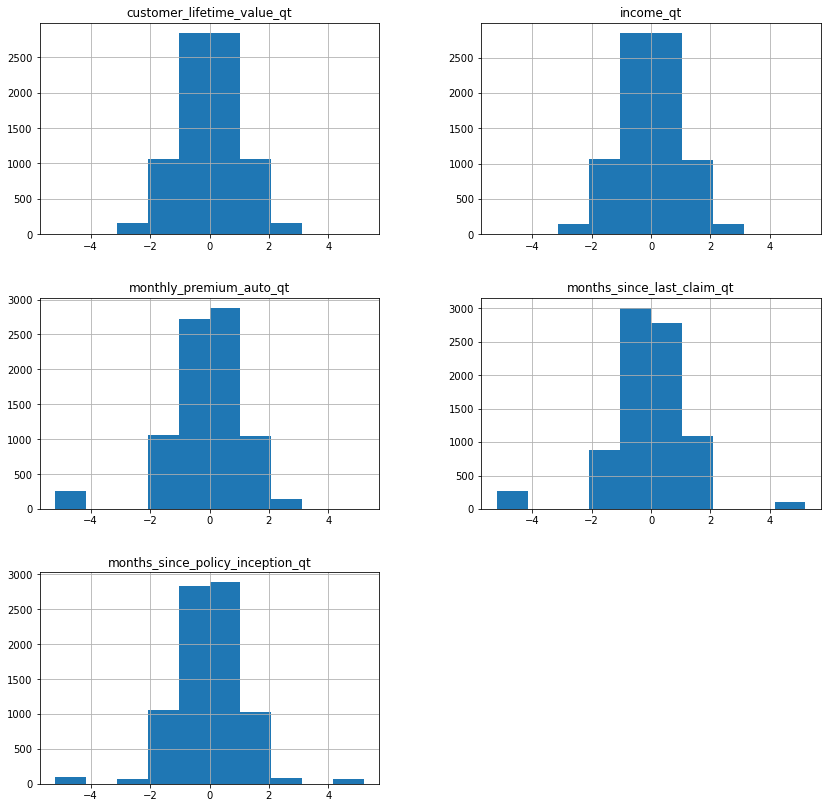

In [178]:
X.hist(figsize=(14,14))

**Concat dummies to numeric standardized**


In [180]:
X = pd.concat([X,cat_cols_no_zero_two],axis=1)
# X

#### Data splitting


In [181]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=42)

#### Standardize

+ Build scaling parameters on training set (mean variance) → more data as approx 80 % of sample <br>

In [182]:
std_scaler=StandardScaler().fit(X_train)

+ Apply on training set

In [183]:
X_train_scaled=std_scaler.transform(X_train)
# np.argwhere(np.isnan(X_train_scaled))

+ as well as on test set (same std_scaler but generated by a bigger set of values), same scaling param's as x_train

In [184]:
X_test_scaled=std_scaler.transform(X_test)

# print("X_train_scaled:")
# print(X_train_scaled)
# print("--------\nX_text_scaled:")
# print(X_test_scaled)

#### Modeling using Statsmodels

In [185]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

In [186]:
model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

In [187]:
X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     412.8
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:06:51   Log-Likelihood:                -35244.
No. Observations:                5686   AIC:                         7.058e+04
Df Residuals:                    5640   BIC:                         7.088e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        377.1056      1.585    237.927      0.0

In [188]:
predictions_test

array([435.53832878, 404.49460519, 524.03191398, ..., 172.57393804,
       226.27582729, 770.6778634 ])

#### Modeling using Scikit Learn

##### Model fitting

In [189]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### Parameters of model

In [190]:
print("Coefficients:", model.coef_)

print("Intercept:", model.intercept_)


Coefficients: [ 1.12162978e+01 -5.27998339e+00  2.29337591e+01  2.65765052e+00
  3.38250320e+00  1.31897215e+00  1.33201403e+00  2.57410679e+00
  3.52172016e+00 -1.02814203e+00  2.78797448e+01  5.04662578e+01
 -9.71802323e-01 -2.49598493e+00  7.87602049e-01  1.17237207e+00
 -5.19598547e+00 -4.98907317e-01 -4.36935747e+00  4.48960777e+00
  1.90053147e+02  9.25527338e+01 -2.64957588e+00  3.02026152e+00
  6.22529801e+13  5.58336324e+13 -1.54983533e+00 -1.73191775e-01
 -4.85476399e+13 -6.05072727e+13 -6.92268836e+13 -2.70480579e+13
 -3.58257103e+13 -3.45575561e+13  3.63823836e+00  1.49163758e+00
  2.98616093e+00 -1.02280006e+00 -1.41848545e+00  2.11917069e+00
  6.24264936e+01  6.87922564e+01  5.18914817e+01  2.59947391e+01
 -2.28858562e+00 -1.19323354e+01 -9.18574313e+00]
Intercept: 377.09979582793926


In [191]:
model.score(X_test_scaled,y_test)

0.7597501479108774

##### Making prediction


In [192]:
y_pred=model.predict(X_test_scaled)

In [193]:
y_test

2625     389.636991
6302     497.047297
7355     527.139074
8803       5.746657
7944    1108.800000
           ...     
5157     114.815893
635      574.024018
2601      40.839965
5088     171.184016
1077     888.000000
Name: total_claim_amount, Length: 2437, dtype: float64

In [194]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### Plots

14168.297964188807


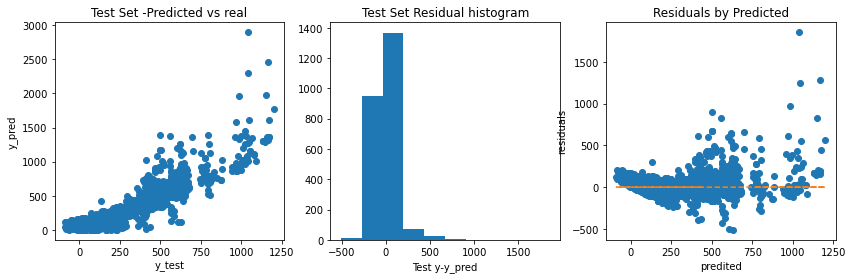

In [195]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')






print(mse(y_train,model.predict(X_train_scaled)))



<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

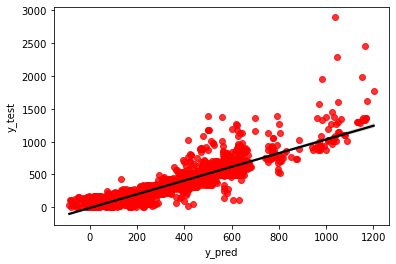

In [196]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

##### Error metrics

In [197]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

16716.337596014804
82.80288061449966


In [198]:
R2=r2_score(y_test,y_pred)
R2

0.7597501479108774

In [199]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.7550235915909993

*** ***

***

###  Play Around DF - nothing of real value... please disregard


+ mean of income *including* the 0 incomes

In [ ]:
np.mean(ca_df["income"])

+ mean of income *excluding* 0 incomes

In [ ]:
np.mean(ca_df[ca_df["income"] != 0]["income"])

In [ ]:
ca_zero_income_mean_df = ca_df

In [ ]:
ca_zero_income_mean_df['income']=ca_zero_income_mean_df['income'].replace(0, np.mean(ca_df[ca_df["income"] != 0]["income"]))

#### Different transformations (more adjustments)

In [ ]:
ca_adjusted = ca_zero_income_mean_df
ca_adjusted.columns

In [ ]:
ca_adjusted.drop("months_since_policy_inception", axis=1, inplace=True)

#### Different transformations (adjusted)

In [ ]:
boxplots_for_all_numerical_cols(split_df_by(ca_adjusted)[0])


In [ ]:
for col in split_column_names_by(ca_adjusted)[0]:
    plot_hist_normalized(ca_adjusted[col])

In [ ]:
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
ca_adjusted["customer_lifetime_value_qt"] = qt.fit_transform(ca_adjusted["customer_lifetime_value"].to_numpy().reshape(-1,1))
ca_adjusted["income_qt"] = qt.fit_transform(ca_adjusted["income"].to_numpy().reshape(-1,1))
ca_adjusted["monthly_premium_auto_qt"] = qt.fit_transform(ca_adjusted["monthly_premium_auto"].to_numpy().reshape(-1,1))
ca_adjusted["months_since_last_claim_qt"] = qt.fit_transform(ca_adjusted["months_since_last_claim"].to_numpy().reshape(-1,1))
# ca_adjusted["months_since_policy_inception_qt"] = qt.fit_transform(ca_adjusted["months_since_policy_inception"].to_numpy().reshape(-1,1))
ca_adjusted.drop(["income","customer_lifetime_value","monthly_premium_auto","months_since_last_claim"], axis=1, inplace=True)
                                                                                                     # ,"months_since_policy_inception"

**Categorical**


In [ ]:
categoricals_features= ca_adjusted.select_dtypes("object")
cat_adjusted_mean=pd.get_dummies(categoricals_features, drop_first=True)

In [ ]:
cat_adjusted_mean


#### X-y split


In [ ]:
X=ca_adjusted.drop("total_claim_amount", axis=1)
y=ca_adjusted["total_claim_amount"]


In [ ]:
X_num.hist(figsize=(14,14))


#### Data splitting


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X_num, y, test_size=.30,random_state=42)


#### Standardize

In [ ]:
std_scaler=StandardScaler().fit(X_train)

In [ ]:
X_train_scaled=std_scaler.transform(X_train)
# np.argwhere(np.isnan(X_train_scaled))

In [ ]:
X_test_scaled=std_scaler.transform(X_test)

# print("X_train_scaled:")
# print(X_train_scaled)
# print("--------\nX_text_scaled:")
# print(X_test_scaled)


#### Modeling using Statsmodels

In [ ]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

In [ ]:
predictions_test

#### Modeling using Scikit Learn

##### Model fitting

In [ ]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train


##### Parameters of model

In [ ]:
print("Coefficients:\n", model.coef_)
print("Interecept:", model.intercept_)

In [ ]:
model.score(X_test_scaled,y_test)

##### Making prediction

In [ ]:
y_pred=model.predict(X_test_scaled)

In [ ]:
y_test

In [ ]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})


##### Plots


In [ ]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

In [ ]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

##### Error metrics

In [ ]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

print(r2_score(y_test,y_pred))

***

***

In [ ]:
### BELOW is old code snippets which will be reused or (more likely) trashed

In [ ]:
cat_col=pd.get_dummies(X["state"], drop_first=False)
cat_col

In [ ]:
# # get dummies pandas
# categoricals_features=pd.get_dummies(categoricals_features, drop_first=True)
# categoricals_features
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(categoricals_features).toarray())
##columns=OneHotEncoder(drop='first').fit(categoricals_features).get_feature_names(input_features=categoricals_feature##s.columns)).head()

In [ ]:
categoricals_features= X.select_dtypes("object")
categoricals_features

select some discrete columns

In [ ]:
X = X[[
 'state',
 'response',
 'coverage',
 'education',
 'effective_to_date',
 'employmentstatus',
 'gender',
 'location_code',
 'marital_status',
 'number_of_open_complaints',
 'number_of_policies',
 'policy_type',
 'policy',
 'renew_offer_type',
 'sales_channel',
 'vehicle_class',
 'vehicle_size',
 'vehicle_type',
 ]]

In [ ]:
categoricals_features= X.select_dtypes("object")
categoricals_features

In [ ]:
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(categoricals_features).toarray())


In [ ]:
# yj = PowerTransformer(method="yeo-johnson")
# no_zero_income_transformed_yj=pt.fit_transform(ca_no_zero_income_df["income"].to_numpy().reshape(-1,1))
# sns.displot(no_zero_income_transformed_yj)